# RMSNorm

1. LayerNorm 有什么缺陷？
2. Norm 的对象是什么？通用 normalization 定义
3. 什么是 RMS
4. RMSNorm 如何计算？
5. RMSNorm 特性
6. RMSNorm 可视化

## LayerNorm 缺陷

LN 在特征向量进行归一化处理，这里的归一化是“标准化”，形如 $\frac{x-\mu}{\sqrt{\sigma^2}}$

1. LN 具有 re-centred 效用 ($x-\mu$)，其与 ReLU-Like 的分布(均值>0)有冲突，导致学习的特征分布反复做“中心化-非中心化”
2. LN 具有缩放 $\gamma$ 和 $\beta$ 参数，在预训练模型中，容易学习到语料预训练的偏置
3. LN 要计算均值、方差，计算较麻烦且耗时

在 3 中，T5 论文提出，$ \gamma \frac{x}{\sqrt{\sigma^2}}$ 模型进行加速，达到上述所有缺陷，但还存留要算 var 的问题。

## Norm 定义

1. 对于序列特征，适合对 token-level 的特征独立做归一化
2. LN 将 token feature（或词向量）进行标准化， 数据方差/标准差变换为 1

对于 “归一化”，通用定义为：对于张量中特定维度进行运算，使得这个维度上的数据的**统计量** 为 1。比如：

1. 对 attention score 归一化则 使用 softmax 变换， 统计量是概率和值为1
2. 对向量数据范围归一化，则使用 $x / \max(|x|) \in [-1,1]$， 统计量是最大值/最小值
3. 对两个向量之间的内积如（ attention score） 除标准差 $ \frac{qk^T} {\sqrt{d}}$ 将分数的分布标准差置 1
4. 向量单位化：将向量除于范数，使得变换后的向量的模长为 1

在 LN 的基础上，找到一个新的统计量对特征变换，不做 re-centred, 不 shift 数据分布

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

In [23]:
# example.1 softmax

x = torch.randn(5)
print(x)
p = F.softmax(x, dim = 0)
print(p)
print(p.sum())

tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229])
tensor([0.2600, 0.2112, 0.2347, 0.2337, 0.0604])
tensor(1.)


In [24]:
# example.2 x to 1

x_range = x / torch.max(x.abs())
print(x_range.max())
# print(x_range.min())

tensor(0.2999)


In [25]:
# example.3 : s

seq_len = 32
dim = 128

q = torch.randn(seq_len, dim)
k = torch.randn(seq_len, dim)
s = q@k.t()
s_norm = q@k.t() / math.sqrt(dim)

print(s.std())
print(s_norm.std()) # 标准差为 1

tensor(11.1394)
tensor(0.9846)


In [26]:
# example.4 : s

x = torch.randn(5)
x_identity = x / x.norm()

print(x.norm())
print(x_identity.norm())

tensor(1.9325)
tensor(1.)


## RMS 统计量

Root-Mean-Square（均根方）是一种数学统计量，有具体的几何意义(感兴趣可以问AI)。

RMS 计算公式为:

$$
RMS(x) = \sqrt{\frac{1}{N} \sum_i x^2_i}
$$

基于 RMS(x) 统计量变换, 本质是向量以尺度 $\frac{1}{RMS(x)}$ 进行缩放
$$
\tilde{x} = \frac{x}{RMS(x)} = x \frac{1}{RMS(x)}
$$

现在计算 RMS($\tilde{x}$)：
$$
RMS(\tilde{x}) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \tilde{x}_i^2} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( \frac{x_i}{RMS(x)} \right)^2}
$$

简化内部表达式：
$$
\left( \frac{x_i}{RMS(x)} \right)^2 = \frac{x_i^2}{(RMS(x))^2}
$$

代入：
$$
RMS(\tilde{x}) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \frac{x_i^2}{(RMS(x))^2}} = \sqrt{ \frac{1}{(RMS(x))^2} \cdot \frac{1}{N} \sum_{i=1}^{N} x_i^2 }
$$

由 RMS(x) 的定义可知：
$$
(RMS(x))^2 = \frac{1}{N} \sum_{i=1}^{N} x_i^2
$$

因此：
$$
RMS(\tilde{x}) = \sqrt{ \frac{1}{(RMS(x))^2} \cdot (RMS(x))^2 } = \sqrt{1} = 1
$$

故，RMS($\tilde{x}$) 恒等于 1，只要 $x$ 不是零向量（即 RMS(x) ≠ 0）。

结论：
$$
\boxed{RMS(\tilde{x})=1}
$$


In [27]:
def RMS(x):
    return torch.sqrt( (x**2).mean() )

x = torch.randn(5)
rms_x = RMS(x)
tilde_x = RMS( x/rms_x ) 

print(rms_x)
print(tilde_x)

tensor(0.7706)
tensor(1.)


1. 计算向量统计量 RMS作为缩放因子， 对向量缩放后得到 $\tilde{x}$， 其 $RMS(\tilde{x})$ 为1
2. 通过一种缩放变换，变换后的向量的某个统计量为1

## RMSNorm 如何计算

上述仅计算 RMS 和 RMS归一化，在网络中有 feature-wise的 $\gamma$ 参数进行学习

In [28]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim)) # 仅有 gamma
        self.eps = eps

    def forward(self, x):
        mean = (x**2).mean(-1, keepdim=True)
        out_mean = x / torch.sqrt(mean + self.eps) # root mean square
        out = self.gamma * out_mean 
        return out

norm = RMSNorm(dim = 512)
x = torch.randn( 2, 6, 512)
x_n = norm(x)
print(x.shape)
print(x_n.shape)

torch.Size([2, 6, 512])
torch.Size([2, 6, 512])


## RMSNorm 特性

RMSNorm 尺度不变性, 即输入缩放 $s>0$ 倍，输出不变

$$
\frac{x}{RMS(x)} = \frac{sx}{RMS(sx)} 
$$

推导:

其中 $ s $ 是一个正标量（$ s > 0 $），且 $x$ 是一个非零向量。

首先，回顾 RMS 的定义：
$$
\text{RMS}(x) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2}
$$

考虑缩放后的向量 $ sx $，其 RMS 为：
$$
\text{RMS}(sx) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (sx_i)^2} = \sqrt{\frac{1}{N} s^2 \sum_{i=1}^{N} x_i^2} = s \sqrt{\frac{1}{N} \sum_{i=1}^{N} x_i^2} = s \cdot \text{RMS}(x)
$$
这里利用了 $ s > 0 $，所以 $ \sqrt{s^2} = s $。

现在计算右边表达式：
$$
\frac{sx}{\text{RMS}(sx)} = \frac{sx}{s \cdot \text{RMS}(x)} = \frac{x}{\text{RMS}(x)}
$$
这与左边表达式相等。

当 $s<0$ 时不成立


In [29]:
def RMSTransform(x):
    rms = torch.sqrt( (x**2).mean() )
    y = x / rms
    return rms, y

x = torch.randn(5)
rms_x, y = RMSTransform(x)
rms_x_3, y_3 = RMSTransform(3*x)

print(rms_x, y)
print(rms_x_3, y_3)

tensor(0.7985) tensor([-0.8957,  1.1680,  1.5985, -0.4630, -0.2532])
tensor(2.3956) tensor([-0.8957,  1.1680,  1.5985, -0.4630, -0.2532])


RMSNorm 具有输入尺度不变性， 反向时，缩放倍数与梯度成反比（可自行推导）

## RMS 可视化

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.manual_seed(42)

class LayerNorm(nn.Module):
    def __init__(self, dim, epsilon = 0.0001):
        super(LayerNorm, self).__init__()
        self.dim = dim 
        self.epsilon = epsilon
        self.gamma = torch.nn.Parameter(torch.ones(self.dim))
        self.beta = torch.nn.Parameter(torch.zeros(self.dim))
                                       
    def forward(self, x):
        mean = torch.mean(x, dim = -1, keepdim = True)
        var = torch.var(x, dim = -1, keepdim = True)
        x_hat = (x - mean) / torch.sqrt(var + self.epsilon)
        x_out = x_hat * self.gamma + self.beta
        return x_out
    
class RMSNorm(nn.Module):
    def __init__(self, dim, epsilon = 0.0001):
        super(RMSNorm, self).__init__()
        self.dim = dim 
        self.epsilon = epsilon
        self.gamma = torch.nn.Parameter(torch.ones(self.dim))
                                        
    def forward(self, x):
        RMS = torch.mean(x ** 2.0 , dim = -1, keepdim = True) 
        x_hat = x / torch.sqrt( RMS + self.epsilon )
        x_out = x_hat * self.gamma 
        return x_out
    
bs = 100
dim = 3
x = torch.randn(bs, 3) + 0.003
linear = nn.Linear(3, 3, bias = False)
ln = LayerNorm(dim)
rms = RMSNorm(dim)
x_proj = linear(x)

x_ln = ln(x_proj)
x_rms = rms(x_proj)
print(x[0,:])
print(x_proj[0,:])
print(x_ln[0,:])
print(x_rms[0,:])

tensor([1.9299, 1.4903, 0.9037])
tensor([ 1.5153, -0.4743,  0.9361], grad_fn=<SliceBackward0>)
tensor([ 0.8367, -1.1074,  0.2707], grad_fn=<SliceBackward0>)
tensor([ 1.4239, -0.4457,  0.8796], grad_fn=<SliceBackward0>)


tensor([1.9299, 1.4903, 0.9037])
tensor([1.5153, 0.4743, 0.9361], grad_fn=<SliceBackward0>)
tensor([ 1.0352, -0.9602, -0.0750], grad_fn=<SliceBackward0>)
tensor([1.4239, 0.4457, 0.8796], grad_fn=<SliceBackward0>)


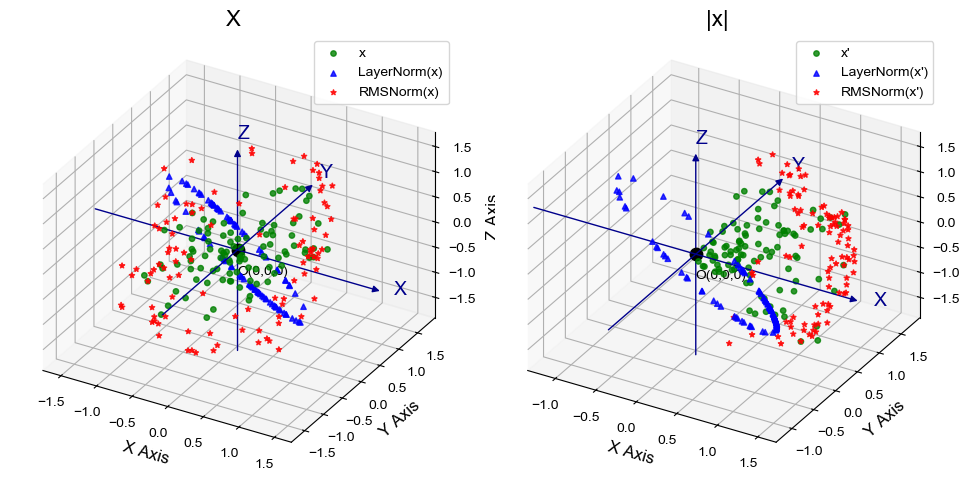

In [34]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

# 自定义3D箭头类
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
scatter_3 = ax.scatter(x_proj[:,0].tolist(), 
                     x_proj[:,1].tolist(), 
                     x_proj[:,2].tolist(), 
                     c='green', s=15, alpha=0.8, label='x',marker='o', )
scatter_2 = ax.scatter(x_ln[:,0].tolist(), 
                     x_ln[:,1].tolist(), 
                     x_ln[:,2].tolist(), 
                     c='blue', s=15, alpha=0.8, 
                    marker='^', label='LayerNorm(x)')
scatter_1 = ax.scatter(x_rms[:,0].tolist(), 
                     x_rms[:,1].tolist(), 
                     x_rms[:,2].tolist(), 
                     c='red', s=15, alpha=0.8, 
                      label = 'RMSNorm(x)',
                    marker='*', )
plt.legend(loc='upper right') 
ax.set_xlabel('X Axis', fontsize=12)
ax.set_ylabel('Y Axis', fontsize=12)
ax.set_zlabel('Z Axis', fontsize=12)
ax.set_title('X', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
arrow_length = 2.0  
arrow_props = dict(mutation_scale=10, arrowstyle='-|>', 
                  color='darkblue', shrinkA=0, shrinkB=0, linewidth=1)
a = Arrow3D([-arrow_length, arrow_length], [0, 0], [0, 0], **arrow_props)
ax.add_artist(a)
ax.text(arrow_length+0.2, 0, 0, "X", fontsize=14, color='darkblue')
b = Arrow3D([0, 0], [-arrow_length, arrow_length], [0, 0], **arrow_props)
ax.add_artist(b)
ax.text(0, arrow_length+0.2, 0, "Y", fontsize=14, color='darkblue')
c = Arrow3D([0, 0], [0, 0], [-arrow_length, arrow_length], **arrow_props)
ax.add_artist(c)
ax.text(0, 0, arrow_length+0.2, "Z", fontsize=14, color='darkblue')
ax.scatter(0, 0, 0, c='black', s=80, marker='o', label='Origin')
ax.text(0, 0, -0.5, "O(0,0,0)", fontsize=10, color='black')
ax.set_proj_type('ortho') 
plt.tight_layout()


x_proj[:,0] = x_proj[:,0].abs()
x_proj[:,1] = x_proj[:,1].abs()



x_ln = ln(x_proj)
x_rms = rms(x_proj)
print(x[0,:])
print(x_proj[0,:])
print(x_ln[0,:])
print(x_rms[0,:])

ax = fig.add_subplot(122, projection='3d')
scatter_3 = ax.scatter(x_proj[:,0].tolist(), 
                     x_proj[:,1].tolist(), 
                     x_proj[:,2].tolist(), 
                     c='green', s=15, alpha=0.8, label='x\'',marker='o', )

scatter_2 = ax.scatter(x_ln[:,0].tolist(), 
                     x_ln[:,1].tolist(), 
                     x_ln[:,2].tolist(), 
                     c='blue', s=15, alpha=0.8, marker='^', label='LayerNorm(x\')')
scatter_1 = ax.scatter(x_rms[:,0].tolist(), 
                     x_rms[:,1].tolist(), 
                     x_rms[:,2].tolist(), 
                     c='red', s=15, alpha=0.8, label = 'RMSNorm(x\')',marker='*', )
plt.legend(loc='upper right') 
ax.set_xlabel('X Axis', fontsize=12)
ax.set_ylabel('Y Axis', fontsize=12)
ax.set_zlabel('Z Axis', fontsize=12)
ax.set_title('|x|', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)
arrow_props = dict(mutation_scale=10, arrowstyle='-|>', 
                  color='darkblue', shrinkA=0, shrinkB=0, linewidth=1)
a = Arrow3D([-arrow_length, arrow_length], [0, 0], [0, 0], **arrow_props)
ax.add_artist(a)
ax.text(arrow_length+0.2, 0, 0, "X", fontsize=14, color='darkblue')
b = Arrow3D([0, 0], [-arrow_length, arrow_length], [0, 0], **arrow_props)
ax.add_artist(b)
ax.text(0, arrow_length+0.2, 0, "Y", fontsize=14, color='darkblue')
c = Arrow3D([0, 0], [0, 0], [-arrow_length, arrow_length], **arrow_props)
ax.add_artist(c)
ax.text(0, 0, arrow_length+0.2, "Z", fontsize=14, color='darkblue')
ax.scatter(0, 0, 0, c='black', s=80, marker='o', label='Origin')
ax.text(0, 0, -0.5, "O(0,0,0)", fontsize=10, color='black')
ax.set_proj_type('ortho') 
plt.tight_layout()

plt.show()

## 总结

1. RMS 是 scaled 式的归一化方案，以 RMS统计量导数 为缩放因子，变换后的数据统计量RMS值恒为1
2. RMSNorm 较 LayerNorm，计算简便、易求导、尺度不变性、梯度方差更小
3. RMSNorm 更易保留特征分布
4. RMSNorm 减轻学习预训练任务偏置

进一步推导：*

1. RMSNorm 求导
2. 输入缩放后，RMSNorm 数据输入x和参数w的梯度不变性分析